In [6]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.distributions as t_dist
from torchsummary import summary

In [2]:
cuda2 = torch.cuda.is_available() #GPU
batch_size2 = 128
log_interval2 = 10
epochs2 = 50

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

In [3]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO

In [4]:
def train(epoch,model):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch,model):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

## Original VAE

In [7]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        x = x.flatten(1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [12]:
vae = VAE().to(device)
summary(vae, input_size=torch.Size([128,1,28,28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                  [-1, 100]          40,100
            Linear-3                    [-1, 2]             202
            Linear-4                    [-1, 2]             202
            Linear-5                  [-1, 100]             300
            Linear-6                  [-1, 400]          40,400
            Linear-7                  [-1, 784]         314,384
Total params: 709,588
Trainable params: 709,588
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 0.01
Params size (MB): 2.71
Estimated Total Size (MB): 3.10
----------------------------------------------------------------


In [38]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train(epoch,vae)
    test(epoch,vae)

====> Epoch: 1 Average loss: 186.9894
====> Test set loss: 166.5981
====> Epoch: 2 Average loss: 162.6421
====> Test set loss: 159.6123
====> Epoch: 3 Average loss: 157.3282
====> Test set loss: 155.3942
====> Epoch: 4 Average loss: 153.8690
====> Test set loss: 152.6145
====> Epoch: 5 Average loss: 151.6072
====> Test set loss: 151.1156
====> Epoch: 6 Average loss: 149.7908
====> Test set loss: 149.8560
====> Epoch: 7 Average loss: 148.4477
====> Test set loss: 148.3642
====> Epoch: 8 Average loss: 147.4312
====> Test set loss: 147.7558
====> Epoch: 9 Average loss: 146.4413
====> Test set loss: 147.0687
====> Epoch: 10 Average loss: 145.7891
====> Test set loss: 146.6211
====> Epoch: 11 Average loss: 145.2901
====> Test set loss: 146.0391
====> Epoch: 12 Average loss: 144.7211
====> Test set loss: 145.9796
====> Epoch: 13 Average loss: 144.2044
====> Test set loss: 145.0427
====> Epoch: 14 Average loss: 143.7316
====> Test set loss: 144.4467
====> Epoch: 15 Average loss: 143.2825
====

## Convolutional VAE

In [16]:
# Define Convolutional VAE model
class Conv_VAE(nn.Module):
    def __init__(self):
        super(Conv_VAE, self).__init__()

        # encoder NN
        self.encConv = nn.Sequential(
             nn.Conv2d(1, 16, 5),
             nn.BatchNorm2d(16),
             nn.LeakyReLU(.2),
            
             nn.Conv2d(16, 32, 5),
             nn.BatchNorm2d(32),
             nn.LeakyReLU(.2)
        )
        
        # fully connected layers
        self.fc1 = nn.Linear(32*20*20, 128)
        self.fc21 = nn.Linear(128, 2) # latent space of 2D
        self.fc22 = nn.Linear(128, 2) # latent space of 2D
        
        # decoder NN
        self.fc3 = nn.Linear(2, 128)
        self.fc4 = nn.Linear(128, 32*20*20)
        self.decConv = nn.Sequential(
             nn.ConvTranspose2d(32, 16, 5),
             nn.BatchNorm2d(16),
             nn.LeakyReLU(.2),
        
             nn.ConvTranspose2d(16, 1, 5),
             nn.Sigmoid())
        
    def encode(self, x):
        x = self.encConv(x)
        x = x.view(-1, 32*20*20) # Flatten
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 32, 20, 20)
        z = self.decConv(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [17]:
conv_vae = Conv_VAE().to(device)
summary(conv_vae, input_size=torch.Size([1,28,28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
       BatchNorm2d-2           [-1, 16, 24, 24]              32
         LeakyReLU-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 20, 20]          12,832
       BatchNorm2d-5           [-1, 32, 20, 20]              64
         LeakyReLU-6           [-1, 32, 20, 20]               0
            Linear-7                  [-1, 128]       1,638,528
            Linear-8                    [-1, 2]             258
            Linear-9                    [-1, 2]             258
           Linear-10                  [-1, 128]             384
           Linear-11                [-1, 12800]       1,651,200
  ConvTranspose2d-12           [-1, 16, 24, 24]          12,816
      BatchNorm2d-13           [-1, 16, 24, 24]              32
        LeakyReLU-14           [-1, 16,

In [40]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO

In [41]:
conv_vae = Conv_VAE().to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train(epoch,conv_vae)
    test(epoch,conv_vae)

====> Epoch: 1 Average loss: 179.5719
====> Test set loss: 161.5395
====> Epoch: 2 Average loss: 156.8677
====> Test set loss: 156.0717
====> Epoch: 3 Average loss: 152.7374
====> Test set loss: 152.2323
====> Epoch: 4 Average loss: 150.4526
====> Test set loss: 150.2881
====> Epoch: 5 Average loss: 149.0382
====> Test set loss: 149.0831
====> Epoch: 6 Average loss: 147.9906
====> Test set loss: 148.2486
====> Epoch: 7 Average loss: 147.1530
====> Test set loss: 148.7135
====> Epoch: 8 Average loss: 146.5443
====> Test set loss: 146.3951
====> Epoch: 9 Average loss: 145.8986
====> Test set loss: 147.9244
====> Epoch: 10 Average loss: 145.4288
====> Test set loss: 146.0830
====> Epoch: 11 Average loss: 144.9561
====> Test set loss: 145.9205
====> Epoch: 12 Average loss: 144.6512
====> Test set loss: 146.8267
====> Epoch: 13 Average loss: 144.1938
====> Test set loss: 145.5800
====> Epoch: 14 Average loss: 143.8300
====> Test set loss: 145.3314
====> Epoch: 15 Average loss: 143.5386
====

In [98]:
def plot_latent_space(model):
    mnist_test = list(test_loader)
    B = len(mnist_test)
    results = torch.zeros((128*B,2))
    all_labels = torch.empty(0)
    l = 0
    for b in range(B):
        labels = mnist_test[b][1]
        all_labels = torch.cat((all_labels, labels))

        images = mnist_test[b][0]
        K = images.shape[0]
        for k in range(K):
            an_img = images[k,:,:,:].unsqueeze(1)
            # an_img_flat = torch.flatten(an_img)
            # if model == vae:
            #     mean_img = model.encode(an_img_flat.to(device))[0]
            # elif model == conv_vae:
            mean_img = model.encode(an_img.to(device))[0]
            results[l] = mean_img
            l +=1
    results = results[:l,:]
    all_labels = all_labels[:l]


    results_for_plot = results.detach().numpy()

    scatter_x = results_for_plot[:,0]
    scatter_y = results_for_plot[:,1]
    group = all_labels

    cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
             5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
    ax.legend(markerscale = 10)
    plt.show()

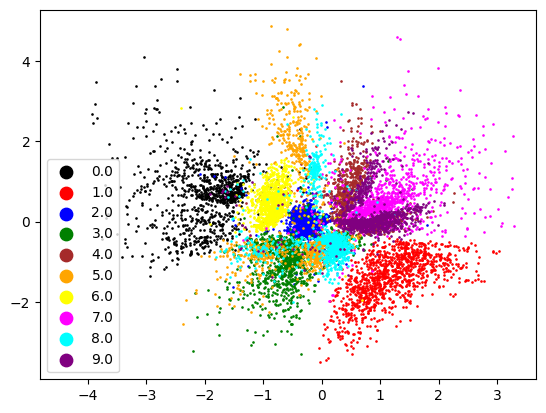

In [97]:
plot_latent_space(vae)

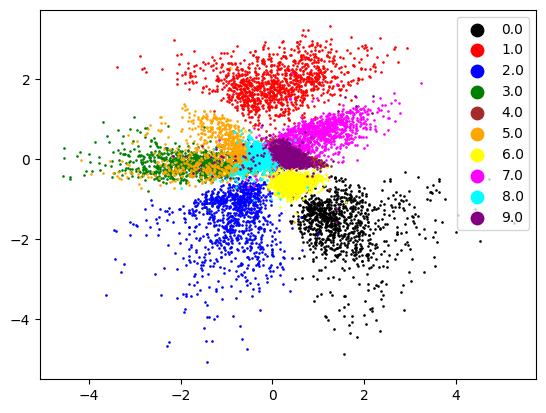

In [99]:
plot_latent_space(conv_vae)

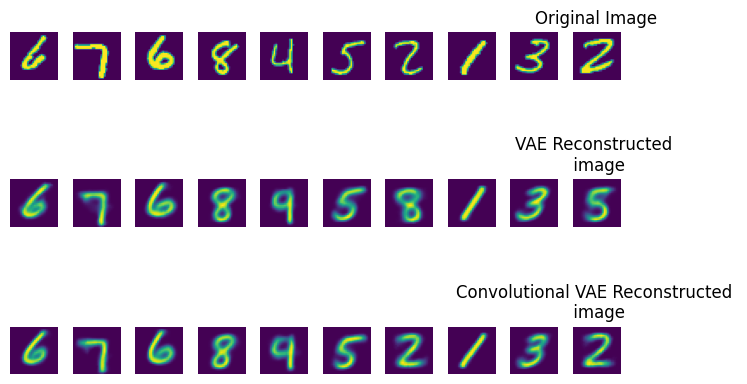

In [94]:
# Compare reconstructed images
img, _ = list(test_loader)[-1]
with torch.no_grad():
    out_2, _, _ = conv_vae(img.to(device))
img = img.reshape(-1, 784) # Reshaping into 1d vector
with torch.no_grad():
    out_1, _, _ = vae(img.to(device))
out_1 = out_1.cpu()
out_2 = out_2.cpu()
counter = 1

# Plotting original images
# Plotting first 15 images
for idx in range(10):
    val = img
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(28, 28))
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
plt.title("Original Image")
# Plotting first 10 images of the batch
for idx in range(10):
    val = out_1
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(28, 28))
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
plt.title("VAE Reconstructed \n image")

for idx in range(10):
    val = out_2
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(28, 28))
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
plt.title("Convolutional VAE Reconstructed \n image")

plt.tight_layout()
plt.savefig("Visualization.png")
plt.show()

In [100]:
conv_vae

Conv_VAE(
  (encConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (fc1): Linear(in_features=12800, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=2, bias=True)
  (fc22): Linear(in_features=128, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=12800, bias=True)
  (decConv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(16, 1, kernel_size=(5, 5), strid

### Calculate likelihood

In [70]:
# using Importance Sampling Estimator
# using encoder as the q distribution
sample_N = 100
p_x_lis = []
with torch.no_grad():
      for model in [vae, conv_vae]:
          for data, _ in test_loader:
              data = data.to(device)

              mu, logvar = model.encode(data)   # batch_size, 2
              q_distribution = t_dist.normal.Normal(mu, (logvar * 0.5).exp())
              z_sample = q_distribution.sample(torch.Size([sample_N])).to(device) # n, batch_size,  2

              q_z = q_distribution.log_prob(z_sample).sum(dim=2)  # n, batch_size

              p_z = t_dist.normal.Normal(torch.tensor(0,).to(device), torch.tensor(1,).to(device)).log_prob(z_sample).sum(dim=2) # n, batch_size

              Bernoulli_p = model.decode(z_sample.view(-1, 2)).view(sample_N, -1, 1, 28, 28 )  # n, batch_size, 1, 28, 28
              p_x_given_z = -1 * F.binary_cross_entropy(Bernoulli_p, \
                  data.unsqueeze(0).expand(sample_N, -1, -1, -1, -1), reduction='none').sum(dim=(-3,-2,-1)) # n, batch_size

              p_x = torch.logsumexp(p_x_given_z + p_z - q_z, dim=0) - torch.log(torch.tensor(sample_N, device=device))
              p_x_lis.append(p_x)

          mean_log_p_x = torch.cat(p_x_lis, dim=0).mean()
          print(model._get_name(), mean_log_p_x)

VAE tensor(-136.5690, device='cuda:0')
Conv_VAE tensor(-137.5681, device='cuda:0')
